### Uncertainty analysis
Using the Monte Carlo Simulations method

In [2]:
import numpy as np
import rasterio as rio
import smca_model
from tqdm import tqdm

In [27]:
# Load the rasters
ksat = rio.open('Rasters/ksat.tif')
wcs = rio.open('Rasters/wcs.tif')
alt_dev = rio.open('Rasters/alt-dev.tif')

In [28]:
# Convert rasters to numpy arrays
ksat_data = ksat.read()
wcs_data = wcs.read()
alt_dev_data = alt_dev.read()


In [29]:
weights = [0.43, 0.14, 0.43]

# Define the type for each criterion
# '1' for benefit, '0' for cost
types = [1, 1, 0]

In [30]:
def mcs_simulation(ksat_data, wcs_data, alt_dev_data, weights, types, n_simulations, std_dev):
    import os

    # Get the shape of the input data (assuming they are 3D arrays with the same shape)
    data_shape = ksat_data.shape[1:]  # This will give (3422, 3398)
    results_path = 'Exports/results_memmap.dat'

    # Ensure Exports directory exists
    os.makedirs('Exports', exist_ok=True)

    # Create a memmap array on disk for results
    results = np.memmap(results_path, dtype='float32', mode='w+', shape=(n_simulations, *data_shape))

    print(f"Running {n_simulations} simulations with standard deviation {std_dev} (on-disk)...")
    for i in tqdm(range(n_simulations)):
        # Generate random weights from a normal distribution centred at the original weights
        random_weights = np.random.normal(weights, std_dev)
        # Ensure weights are positive
        random_weights = np.abs(random_weights)
        # Normalise weights so they sum to 1
        random_weights = random_weights / np.sum(random_weights)
        # Run the smca_model with the random weights
        result = smca_model.model(ksat_data, wcs_data, alt_dev_data, random_weights, types)
        # Set values outside a certain threshold to NaN (e.g., smaller than 0 or larger than 1e34)
        result[(result < 0) | (result > 1e34)] = np.nan
        # Write result to memmap
        results[i] = result
        del result

    print("Simulation completed.")
    print("Beginning to calculate statistics...")

    # Flush memmap to disk
    results.flush()

    # Re-open memmap in read-only mode for statistics
    results = np.memmap(results_path, dtype='float32', mode='r', shape=(n_simulations, *data_shape))

    # Calculate statistics from the results, then save to file
    min_rank = np.nanmin(results, axis=0)
    np.save('Exports/min_rank.npy', min_rank)
    del min_rank
    max_rank = np.nanmax(results, axis=0)
    np.save('Exports/max_rank.npy', max_rank)
    del max_rank
    average_rank = np.nanmean(results, axis=0)
    np.save('Exports/average_rank.npy', average_rank)
    del average_rank
    std_dev_rank = np.nanstd(results, axis=0)
    np.save('Exports/std_dev_rank.npy', std_dev_rank)
    del std_dev_rank

    print("Statistics calculated.")
    # Optionally, remove the memmap file to save disk space
    # os.remove(results_path)
    return

In [31]:
# Example usage:
mcs_simulation(
    ksat_data, wcs_data, alt_dev_data, weights, types, n_simulations=100, std_dev=0.1
)

Running 100 simulations with standard deviation 0.1 (on-disk)...


100%|██████████| 100/100 [00:24<00:00,  4.07it/s]


Simulation completed.
Beginning to calculate statistics...


/tmp/ipykernel_3979/2370094473.py:40: RuntimeWarning: All-NaN slice encountered
  min_rank = np.nanmin(results, axis=0)
/tmp/ipykernel_3979/2370094473.py:43: RuntimeWarning: All-NaN slice encountered
  max_rank = np.nanmax(results, axis=0)
/tmp/ipykernel_3979/2370094473.py:46: RuntimeWarning: Mean of empty slice
  average_rank = np.nanmean(results, axis=0)
/home/vscode/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Statistics calculated.


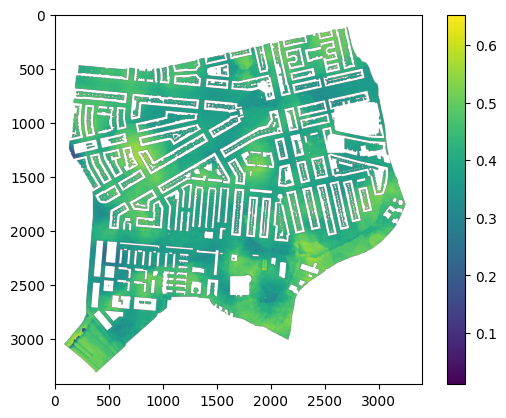

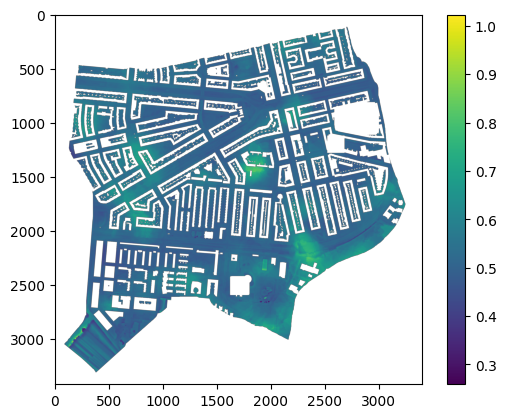

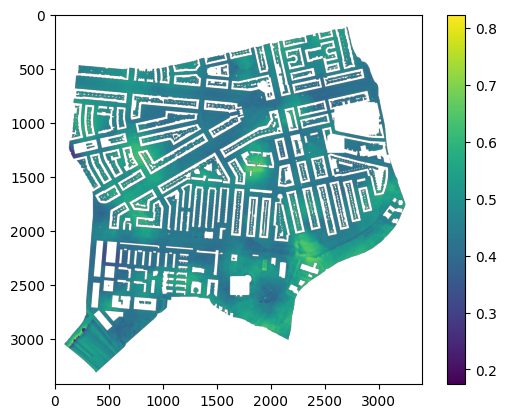

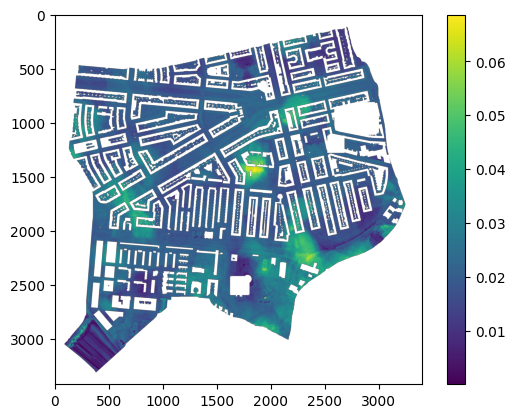

In [6]:
# Plot min_rank
# You can then analyze or plot these results as needed
# For example, using matplotlib to visualize the average_rank
# Set nodata values to NaN for better visualization
import matplotlib.pyplot as plt

ranks = ['Exports/min_rank.npy',
         'Exports/max_rank.npy',
         'Exports/average_rank.npy',
         'Exports/std_dev_rank.npy']

for rank in ranks:
    data = np.load(rank)
    
    plt.imshow(data, cmap='viridis')
    plt.colorbar()
    plt.savefig(f'Exports/{rank.split("/")[-1].replace(".npy", ".svg")}', format='svg', dpi=150)
    plt.show()
    plt.close()